<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/ai_translation_tuning_sft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Supervised Tuning**

*Task: Automatically tune and evaluate translation models for multiple long-tail languages*


https://cloud.google.com/vertex-ai/generative-ai/docs/models/translation-supervised-tuning

In [ ]:
# Update project ID, GCP bucket name and name of TMX file manually:

PROJECT_ID = "YOUR-PROJECT-ID"               # <--- UPDATE THIS
LOCATION = "us-central1"
BUCKET_NAME = "translations-eval" # <--- UPDATE THIS
BUCKET_URI = f"gs://{BUCKET_NAME}"
TMX_GCS_PATH = "samples.tmx"    # <--- UPLOAD THIS
LOCAL_TMX_FILE = "samples.tmx"

###### *Setup and Dependencies*

In [ ]:
%pip install --upgrade google-cloud-aiplatform google-cloud-storage -q
%pip install matplotlib seaborn langdetect -q
%pip install --upgrade --user --quiet google-cloud-aiplatform[evaluation]

!pip install google-cloud-translate==2.0.1 -q
!pip install --upgrade google-cloud-translate -q

import xml.etree.ElementTree as ET
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from google.cloud import aiplatform, storage
from google.cloud import translate_v3 as translate
import vertexai
from vertexai.tuning import sft
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
import re
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# For language detection
from langdetect import detect, detect_langs

In [ ]:
# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=LOCATION)

# Utility Functions
def download_from_gcs(bucket_name, source_blob_name, destination_file_name):
    """Downloads a file from GCS and returns the local path."""
    print(f"--- Downloading {source_blob_name} ---")
    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    print(f"Successfully downloaded to {destination_file_name}")
    return destination_file_name

def upload_to_gcs(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to GCS and returns the GCS URI."""
    print(f"--- Uploading {source_file_name} ---")
    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    gcs_uri = f"gs://{bucket_name}/{destination_blob_name}"
    print(f"Successfully uploaded to {gcs_uri}")
    return gcs_uri

###### *Automatic **Data Analysis** of TMX File*

STEP 1: TMX FILE ANALYSIS
--- Downloading podcast_sample_tm.tmx ---
Successfully downloaded to podcast_sample_tm.tmx

 Detecting languages in TMX file...
 Detected 5 languages:
   - de-DE
   - en (SOURCE)
   - es-LA
   - fr-FR
   - pt-BR

 Extracting translation data...
 Processed 826 translation units

 Extraction Summary:
Language  Translation Pairs  Status
   de-DE                211 ✅ Ready
   es-LA                209 ✅ Ready
   fr-FR                195 ✅ Ready
   pt-BR                211 ✅ Ready

 Computing Basic Statistics...

Language  Samples  Avg Source  Avg Target Ratio Source Range Target Range
   es-LA      209 14.4 ± 14.8 12.6 ± 13.1  0.87         1-94         1-90
   pt-BR      211 14.3 ± 14.8 13.1 ± 13.3  0.92         1-94         1-92
   fr-FR      195 15.0 ± 15.2 14.6 ± 14.4  0.98         1-94         1-86
   de-DE      211 14.3 ± 14.8 13.6 ± 13.7  0.95         1-94         1-96

 Computing Advanced Statistics...

 Vocabulary Statistics:
Language Src Vocab Src Tokens S

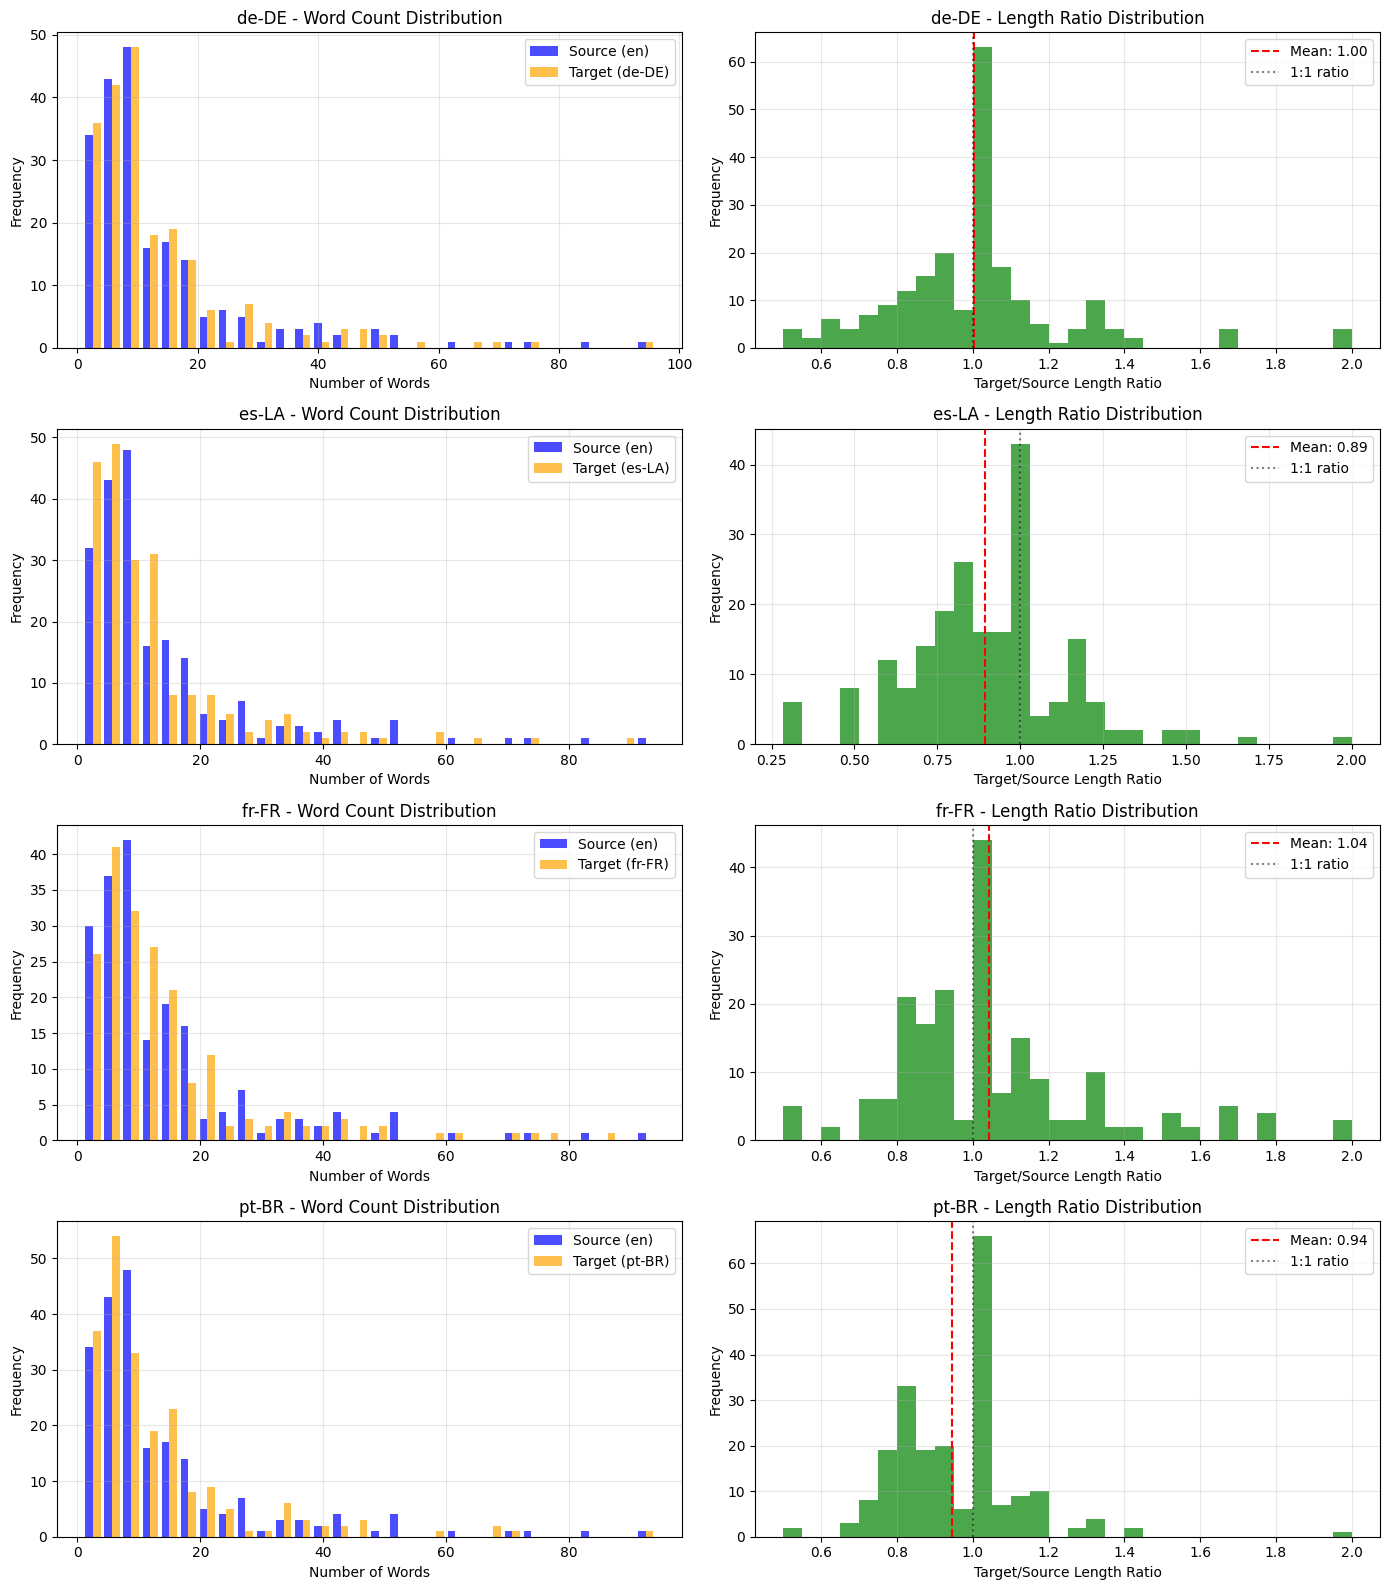


 Sample Previews:

--- de-DE - First 3 samples ---

Sample 1:
  Source (en): But that whole natural selection thing when it comes to plants is so fascinating.
  Target (de-DE): Diese ganze natürliche Auslese bei Pflanzen ist so faszinierend.

Sample 2:
  Source (en): I'm so excited to have you here.
  Target (de-DE): Ich freue mich so, dass du hier bist.

Sample 3:
  Source (en): gentlemen. Mr. Corsetti, how are you? Sorry. Very nice to meet you by the way.
  Target (de-DE): Die Herren. Mr. Corsetti, wie geht es Ihnen? Sorry. Ich freue mich übrigens sehr, Sie kennenzulernen.

--- es-LA - First 3 samples ---

Sample 1:
  Source (en): Because it appears you’ve been really thinking and working on the subject matter of sleep for about sort of 20 odd years, 2 decades roughly.
  Target (es-LA): Porque, al parecer, has estado pensando y trabajando en el tema del sueño durante unos 20 años o 2 décadas, aproximadamente.

Sample 2:
  Source (en): Very nice to meet you by the way.
  Target (es-L

In [ ]:
# @title STEP 1: TMX FILE ANALYSIS
# ============================================================================

class TMXAnalyzer:
    """Comprehensive TMX file analyzer with automatic language detection."""

    def __init__(self, tmx_path: str):
        self.tmx_path = tmx_path
        self.tree = ET.parse(tmx_path)
        self.root = self.tree.getroot()
        # Correct namespace for xml:lang attribute
        self.lang_attr = '{http://www.w3.org/XML/1998/namespace}lang'
        self.data = defaultdict(list)
        self.statistics = {}
        self.detected_languages = set()
        self.source_lang = None

    def detect_languages(self):
        """Automatically detect all languages in the TMX file."""
        print("\n Detecting languages in TMX file...")

        # Find all unique language codes
        for tuv in self.root.findall('.//tuv'):
            lang_code = tuv.get(self.lang_attr)
            if lang_code:
                self.detected_languages.add(lang_code)

        # Identify source language (usually English 'en' or 'en-US')
        en_variants = [lang for lang in self.detected_languages if lang.startswith('en')]
        if en_variants:
            self.source_lang = en_variants[0]
        elif self.detected_languages:
            # If no English, use the first language as source
            self.source_lang = sorted(list(self.detected_languages))[0]

        print(f" Detected {len(self.detected_languages)} languages:")
        for lang in sorted(self.detected_languages):
            marker = " (SOURCE)" if lang == self.source_lang else ""
            print(f"   - {lang}{marker}")

        return self.detected_languages

    def extract_all_data(self) -> Dict:
        """Extract all translation units from TMX file."""
        print("\n Extracting translation data...")

        if not self.detected_languages:
            self.detect_languages()

        # Process each translation unit
        tu_count = 0
        for tu in self.root.findall('.//tu'):
            tu_count += 1

            # Get source text
            source_tuv = tu.find(f"tuv[@{self.lang_attr.split('}')[1]}='{self.source_lang}']",
                                {'xml': 'http://www.w3.org/XML/1998/namespace'})

            # If can't find with namespace prefix, try direct search
            if source_tuv is None:
                for tuv in tu.findall('tuv'):
                    if tuv.get(self.lang_attr) == self.source_lang:
                        source_tuv = tuv
                        break

            if source_tuv is None or source_tuv.find('seg') is None:
                continue

            source_seg = source_tuv.find('seg')
            if source_seg is None or source_seg.text is None:
                continue

            source_text = source_seg.text.strip()

            # Get all target translations
            for tuv in tu.findall('tuv'):
                lang_code = tuv.get(self.lang_attr)

                # Skip source language and empty lang codes
                if not lang_code or lang_code == self.source_lang:
                    continue

                seg = tuv.find('seg')
                if seg is not None and seg.text:
                    target_text = seg.text.strip()

                    self.data[lang_code].append({
                        'source': source_text,
                        'target': target_text,
                        'source_words': len(source_text.split()),
                        'target_words': len(target_text.split()),
                        'source_chars': len(source_text),
                        'target_chars': len(target_text)
                    })

        print(f" Processed {tu_count} translation units")

        # Create extraction summary table
        if self.data:
            extraction_summary = []
            for lang, samples in sorted(self.data.items()):
                extraction_summary.append({
                    'Language': lang,
                    'Translation Pairs': len(samples),
                    'Status': '✅ Ready' if len(samples) > 10 else ' Low samples'
                })

            print("\n Extraction Summary:")
            extraction_df = pd.DataFrame(extraction_summary)
            print(extraction_df.to_string(index=False))

        return self.data

    def compute_basic_statistics(self):
        """Compute basic statistics for each language pair."""
        print("\n Computing Basic Statistics...")

        if not self.data:
            print(" No data to analyze. Skipping statistics.")
            return

        for lang_code, samples in self.data.items():
            if not samples:
                continue

            df = pd.DataFrame(samples)

            stats = {
                'language_code': lang_code,
                'total_samples': len(samples),
                'avg_source_words': df['source_words'].mean(),
                'avg_target_words': df['target_words'].mean(),
                'avg_source_chars': df['source_chars'].mean(),
                'avg_target_chars': df['target_chars'].mean(),
                'length_ratio_words': df['target_words'].mean() / df['source_words'].mean() if df['source_words'].mean() > 0 else 0,
                'length_ratio_chars': df['target_chars'].mean() / df['source_chars'].mean() if df['source_chars'].mean() > 0 else 0,
                'min_source_words': df['source_words'].min(),
                'max_source_words': df['source_words'].max(),
                'min_target_words': df['target_words'].min(),
                'max_target_words': df['target_words'].max(),
                'std_source_words': df['source_words'].std(),
                'std_target_words': df['target_words'].std()
            }

            self.statistics[lang_code] = stats

        # Create and display basic statistics table
        basic_stats_data = []
        for lang_code, stats in self.statistics.items():
            basic_stats_data.append({
                'Language': lang_code,
                'Samples': stats['total_samples'],
                'Avg Source': f"{stats['avg_source_words']:.1f} ± {stats['std_source_words']:.1f}",
                'Avg Target': f"{stats['avg_target_words']:.1f} ± {stats['std_target_words']:.1f}",
                'Ratio': f"{stats['length_ratio_words']:.2f}",
                'Source Range': f"{stats['min_source_words']}-{stats['max_source_words']}",
                'Target Range': f"{stats['min_target_words']}-{stats['max_target_words']}"
            })

        basic_df = pd.DataFrame(basic_stats_data)
        print("\n" + basic_df.to_string(index=False))

    def compute_advanced_statistics(self):
        """Compute advanced statistics including vocabulary and quality metrics."""
        print("\n Computing Advanced Statistics...")

        if not self.data:
            print(" No data to analyze. Skipping advanced statistics.")
            return

        for lang_code, samples in self.data.items():
            if not samples:
                continue

            # Token and vocabulary statistics
            source_tokens = []
            target_tokens = []
            for sample in samples:
                source_tokens.extend(sample['source'].lower().split())
                target_tokens.extend(sample['target'].lower().split())

            source_vocab = set(source_tokens)
            target_vocab = set(target_tokens)
            source_freq = Counter(source_tokens)
            target_freq = Counter(target_tokens)

            # Duplication analysis
            source_texts = [s['source'] for s in samples]
            target_texts = [s['target'] for s in samples]
            pairs = [(s['source'], s['target']) for s in samples]

            duplicate_pairs = len(pairs) - len(set(pairs))
            duplicate_sources = len(source_texts) - len(set(source_texts))

            # Find sources with multiple translations
            source_to_targets = defaultdict(set)
            for s in samples:
                source_to_targets[s['source']].add(s['target'])
            ambiguous_sources = sum(1 for targets in source_to_targets.values() if len(targets) > 1)

            # Empty or truncated segments
            empty_sources = sum(1 for s in samples if not s['source'].strip())
            empty_targets = sum(1 for s in samples if not s['target'].strip())
            short_sources = sum(1 for s in samples if s['source_words'] < 3)
            short_targets = sum(1 for s in samples if s['target_words'] < 3)

            # Punctuation consistency
            punct_mismatch = sum(1 for s in samples
                               if (s['source'].endswith('.') != s['target'].endswith('.')) or
                                  (s['source'].endswith('?') != s['target'].endswith('?')) or
                                  (s['source'].endswith('!') != s['target'].endswith('!')))

            advanced_stats = {
                'source_vocab_size': len(source_vocab),
                'target_vocab_size': len(target_vocab),
                'source_total_tokens': len(source_tokens),
                'target_total_tokens': len(target_tokens),
                'source_top_10_words': source_freq.most_common(10),
                'target_top_10_words': target_freq.most_common(10),
                'duplicate_pairs': duplicate_pairs,
                'duplicate_sources': duplicate_sources,
                'ambiguous_sources': ambiguous_sources,
                'empty_sources': empty_sources,
                'empty_targets': empty_targets,
                'short_sources': short_sources,
                'short_targets': short_targets,
                'punct_mismatch': punct_mismatch,
                'rare_words_source': sum(1 for count in source_freq.values() if count == 1),
                'rare_words_target': sum(1 for count in target_freq.values() if count == 1),
                'type_token_ratio_source': len(source_vocab) / len(source_tokens) if source_tokens else 0,
                'type_token_ratio_target': len(target_vocab) / len(target_tokens) if target_tokens else 0
            }

            if lang_code not in self.statistics:
                self.statistics[lang_code] = {}
            self.statistics[lang_code].update(advanced_stats)

        # Create vocabulary statistics table
        vocab_data = []
        quality_data = []

        for lang_code, stats in self.statistics.items():
            vocab_data.append({
                'Language': lang_code,
                'Src Vocab': f"{stats.get('source_vocab_size', 0):,}",
                'Src Tokens': f"{stats.get('source_total_tokens', 0):,}",
                'Src TTR': f"{stats.get('type_token_ratio_source', 0):.3f}",
                'Tgt Vocab': f"{stats.get('target_vocab_size', 0):,}",
                'Tgt Tokens': f"{stats.get('target_total_tokens', 0):,}",
                'Tgt TTR': f"{stats.get('type_token_ratio_target', 0):.3f}",
                'Rare Src': stats.get('rare_words_source', 0),
                'Rare Tgt': stats.get('rare_words_target', 0)
            })

            quality_data.append({
                'Language': lang_code,
                'Duplicates': stats.get('duplicate_pairs', 0),
                'Ambiguous': stats.get('ambiguous_sources', 0),
                'Short Src': stats.get('short_sources', 0),
                'Short Tgt': stats.get('short_targets', 0),
                'Empty': stats.get('empty_sources', 0) + stats.get('empty_targets', 0),
                'Punct Mismatch': stats.get('punct_mismatch', 0)
            })

        print("\n Vocabulary Statistics:")
        vocab_df = pd.DataFrame(vocab_data)
        print(vocab_df.to_string(index=False))

        print("\n Quality Issues Summary:")
        quality_df = pd.DataFrame(quality_data)
        print(quality_df.to_string(index=False))

        # Show top words for each language
        print("\n Top 5 Words per Language:")
        for lang_code, stats in self.statistics.items():
            if 'source_top_10_words' in stats:
                top_words = ', '.join([f'{word}({count})' for word, count in stats['source_top_10_words'][:5]])
                print(f"   {lang_code}: {top_words}")

    def verify_language_detection(self, sample_size=30):
        """Verify language detection for quality assurance."""
        print("\n Verifying Language Detection (using langdetect)...")

        if not self.data:
            print(" No data to verify.")
            return

        detection_results = []

        for lang_code, samples in self.data.items():
            if not samples:
                continue

            # Sample random texts for language detection
            sample_targets = [s['target'] for s in samples[:min(sample_size, len(samples))]]

            detected_langs = []
            for text in sample_targets:
                try:
                    detected = detect(text)
                    detected_langs.append(detected)
                except:
                    detected_langs.append('unknown')

            lang_detection_accuracy = Counter(detected_langs)

            # Get top detected language and its accuracy
            if lang_detection_accuracy:
                top_detected = lang_detection_accuracy.most_common(1)[0]
                accuracy = (top_detected[1] / len(sample_targets)) * 100

                # Get all detected languages as string
                all_detected = ', '.join([f"{lang}({count})" for lang, count in lang_detection_accuracy.most_common(3)])

                detection_results.append({
                    'Language': lang_code,
                    'Primary Detection': top_detected[0],
                    'Accuracy': f"{accuracy:.1f}%",
                    'Sample Size': len(sample_targets),
                    'All Detected': all_detected
                })

        if detection_results:
            detection_df = pd.DataFrame(detection_results)
            print("\n" + detection_df.to_string(index=False))

    def visualize_statistics(self):
        """Create visualizations for sentence length distributions."""
        print("\n Creating Visualizations...")

        if not self.data:
            print(" No data to visualize.")
            return

        num_langs = len(self.data)
        if num_langs == 0:
            print(" No languages found to visualize.")
            return

        fig, axes = plt.subplots(num_langs, 2, figsize=(14, 4*num_langs))
        if num_langs == 1:
            axes = axes.reshape(1, -1)

        for idx, (lang_code, samples) in enumerate(sorted(self.data.items())):
            if not samples:
                continue

            df = pd.DataFrame(samples)

            # Word length distribution
            axes[idx, 0].hist([df['source_words'], df['target_words']],
                             bins=30, alpha=0.7, label=[f'Source ({self.source_lang})', f'Target ({lang_code})'],
                             color=['blue', 'orange'])
            axes[idx, 0].set_title(f'{lang_code} - Word Count Distribution')
            axes[idx, 0].set_xlabel('Number of Words')
            axes[idx, 0].set_ylabel('Frequency')
            axes[idx, 0].legend()
            axes[idx, 0].grid(True, alpha=0.3)

            # Length ratio distribution
            if df['source_words'].min() > 0:
                length_ratios = df['target_words'] / df['source_words']
                axes[idx, 1].hist(length_ratios, bins=30, alpha=0.7, color='green')
                axes[idx, 1].axvline(length_ratios.mean(), color='red',
                                   linestyle='--', label=f'Mean: {length_ratios.mean():.2f}')
                axes[idx, 1].axvline(1.0, color='black', linestyle=':', alpha=0.5, label='1:1 ratio')
                axes[idx, 1].set_title(f'{lang_code} - Length Ratio Distribution')
                axes[idx, 1].set_xlabel('Target/Source Length Ratio')
                axes[idx, 1].set_ylabel('Frequency')
                axes[idx, 1].legend()
                axes[idx, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def preview_samples(self, num_samples=5):
        """Preview sample translations for each language."""
        print("\n Sample Previews:")

        if not self.data:
            print(" No data to preview.")
            return

        for lang_code, samples in sorted(self.data.items()):
            if not samples:
                continue

            print(f"\n--- {lang_code} - First {min(num_samples, len(samples))} samples ---")

            for i, sample in enumerate(samples[:num_samples], 1):
                print(f"\nSample {i}:")
                print(f"  Source ({self.source_lang}): {sample['source'][:150]}")
                if len(sample['source']) > 150:
                    print("  ...")
                print(f"  Target ({lang_code}): {sample['target'][:150]}")
                if len(sample['target']) > 150:
                    print("  ...")

    def get_summary_dataframe(self):
        """Get a comprehensive summary DataFrame of all statistics."""
        if not self.statistics:
            print(" No statistics available.")
            return pd.DataFrame()

        summary_data = []
        for lang_code, stats in self.statistics.items():
            summary_data.append({
                'Language': lang_code,
                'Samples': stats.get('total_samples', 0),
                'Clean': stats.get('total_samples', 0) - stats.get('duplicate_pairs', 0) - stats.get('short_sources', 0) - stats.get('short_targets', 0),
                'Avg Words': f"{stats.get('avg_source_words', 0):.1f}/{stats.get('avg_target_words', 0):.1f}",
                'Length Ratio': f"{stats.get('length_ratio_words', 0):.2f}",
                'Vocabulary': f"{stats.get('source_vocab_size', 0)}/{stats.get('target_vocab_size', 0)}",
                'TTR': f"{stats.get('type_token_ratio_source', 0):.3f}/{stats.get('type_token_ratio_target', 0):.3f}",
                'Issues': stats.get('duplicate_pairs', 0) + stats.get('short_sources', 0) + stats.get('short_targets', 0),
                'Quality %': f"{((stats.get('total_samples', 0) - stats.get('duplicate_pairs', 0) - stats.get('short_sources', 0) - stats.get('short_targets', 0)) / stats.get('total_samples', 1) * 100):.1f}%"
            })

        return pd.DataFrame(summary_data)

# STEP 1: Download and Analyze TMX File
print("="*80)
print("STEP 1: TMX FILE ANALYSIS")
print("="*80)

# Download TMX file
download_from_gcs(BUCKET_NAME, TMX_GCS_PATH, LOCAL_TMX_FILE)

# Initialize analyzer
analyzer = TMXAnalyzer(LOCAL_TMX_FILE)

# Detect languages first
detected_langs = analyzer.detect_languages()

# Extract all data
all_language_data = analyzer.extract_all_data()

# Only proceed with analysis if data was found
if all_language_data:
    # Compute all statistics
    analyzer.compute_basic_statistics()
    analyzer.compute_advanced_statistics()
    analyzer.verify_language_detection()

    # Visualizations
    analyzer.visualize_statistics()

    # Preview samples
    analyzer.preview_samples(num_samples=3)

    # Comprehensive summary table
    print("\n" + "="*80)
    print(" COMPREHENSIVE SUMMARY")
    print("="*80)
    summary_df = analyzer.get_summary_dataframe()
    print(summary_df.to_string(index=False))
    print("\nLegend:")
    print("- Avg Words: Source/Target average word counts")
    print("- Vocabulary: Source/Target unique word counts")
    print("- TTR: Type-Token Ratio (vocabulary diversity)")
    print("- Clean: Samples after removing duplicates and short segments")
    print("- Quality %: Percentage of clean samples")
else:
    print("\n No translation data found in TMX file!")
    print("Please check that the TMX file contains valid translation units.")


###### *Automatic **Preprocessing** of all Languages*

In [ ]:
# @title STEP 2: AUTOMATIC TXM PREPROCESSING FOR ALL LANGUAGES
# ============================================================================

def create_tuning_data_from_samples(samples, lang_code):
    """Convert samples to the required 'contents' format for tuning."""
    tuning_records = []
    for sample in samples:
        json_record = {
            "contents": [
                {"role": "user", "parts": [{"text": f"English: {sample['source']} {lang_code}: "}]},
                {"role": "model", "parts": [{"text": sample['target']}]}
            ]
        }
        tuning_records.append(json_record)
    return tuning_records

def preprocess_and_upload_language(lang_code, samples):
    """Preprocess and upload data for a single language."""
    print(f"\n Automatic Processing {lang_code}...")

    # Remove duplicates and short samples
    unique_samples = []
    seen_pairs = set()
    for sample in samples:
        pair = (sample['source'], sample['target'])
        if pair not in seen_pairs and sample['source_words'] >= 3 and sample['target_words'] >= 3:
            seen_pairs.add(pair)
            unique_samples.append(sample)

    print(f"   Filtered from {len(samples)} to {len(unique_samples)} unique quality samples")

    if len(unique_samples) < 10:
        print(f"   ⚠️ Skipping {lang_code} - insufficient samples after filtering")
        return None

    # Convert to tuning format
    tuning_records = create_tuning_data_from_samples(unique_samples, lang_code)

    # Split into train/eval
    train_data, eval_data = train_test_split(tuning_records, test_size=0.2, random_state=42)
    print(f"   Split: {len(train_data)} training, {len(eval_data)} evaluation")

    # Save and upload train data
    train_file_local = f"{lang_code.replace(':', '_')}_tuning_train_split.jsonl"
    with open(train_file_local, 'w', encoding='utf-8') as f:
        for item in train_data:
            f.write(json.dumps(item) + '\n')
    train_gcs_uri = upload_to_gcs(BUCKET_NAME, train_file_local, f"datasets/{train_file_local}")

    # Save and upload eval data
    eval_file_local = f"{lang_code.replace(':', '_')}_tuning_eval_split.jsonl"
    with open(eval_file_local, 'w', encoding='utf-8') as f:
        for item in eval_data:
            f.write(json.dumps(item) + '\n')
    eval_gcs_uri = upload_to_gcs(BUCKET_NAME, eval_file_local, f"datasets/{eval_file_local}")

    return {
        'lang_code': lang_code,
        'train_uri': train_gcs_uri,
        'eval_uri': eval_gcs_uri,
        'train_count': len(train_data),
        'eval_count': len(eval_data)
    }

print("\n" + "="*80)
print("STEP 2: PREPROCESSING AND UPLOADING ALL LANGUAGES")
print("="*80)

# Process all languages
preprocessing_results = []
if all_language_data:
    for lang_code, samples in all_language_data.items():
        result = preprocess_and_upload_language(lang_code, samples)
        if result:
            preprocessing_results.append(result)

    # Summary of preprocessing
    if preprocessing_results:
        print("\n Preprocessing Summary:")
        prep_df = pd.DataFrame(preprocessing_results)
        # Reorder columns for better readability
        prep_df = prep_df[['lang_code', 'train_count', 'eval_count']]
        prep_df.columns = ['Language', 'Training Samples', 'Evaluation Samples']
        prep_df['Total'] = prep_df['Training Samples'] + prep_df['Evaluation Samples']
        prep_df['Split'] = prep_df.apply(lambda x: f"{x['Training Samples']}/{x['Evaluation Samples']} (80/20)", axis=1)
        print(prep_df[['Language', 'Total', 'Split']].to_string(index=False))
    else:
        print("\n⚠️ No languages had sufficient data for preprocessing")
else:
    print("\n⚠️ No data available for preprocessing")


###### *Automatic **Supervised Tuning** of all Languages*

In [ ]:
# @title STEP 3: AUTOMATIC MODEL TUNING FOR ALL LANGUAGES
# ============================================================================

def launch_tuning_job(prep_result):
    """Launch a tuning job for a single language."""
    lang_code = prep_result['lang_code']

    # Create a safe model name
    safe_lang_code = lang_code.lower().replace('-', '_').replace(':', '_')
    model_display_name = f'tuned-translator-{safe_lang_code}'

    print(f"\n Launching tuning job for {lang_code}...")

    try:
        sft_tuning_job = sft.train(
            source_model="translation-llm-002",
            train_dataset=prep_result['train_uri'],
            validation_dataset=prep_result['eval_uri'],
            tuned_model_display_name=model_display_name,
        )

        print(f"   ✅ Job submitted for {lang_code}")
        print(f"   Job Name: {sft_tuning_job.resource_name}")

        return {
            'lang_code': lang_code,
            'job': sft_tuning_job,
            'job_name': sft_tuning_job.resource_name,
            'model_name': model_display_name,
            'status': 'submitted',
            'start_time': datetime.now()
        }
    except Exception as e:
        print(f"   ❌ Failed to submit job for {lang_code}: {str(e)}")
        return {
            'lang_code': lang_code,
            'job': None,
            'error': str(e),
            'status': 'failed'
        }

def monitor_tuning_jobs(tuning_jobs, check_interval=300):
    """Monitor all tuning jobs until completion."""
    print("\n Monitoring tuning jobs...")

    active_jobs = tuning_jobs.copy()
    completed_jobs = []

    while active_jobs:
        time.sleep(check_interval)

        for job_info in active_jobs[:]:
            if job_info['job'] is None:
                active_jobs.remove(job_info)
                completed_jobs.append(job_info)
                continue

            try:
                job_info['job'].refresh()

                if job_info['job'].has_ended:
                    job_info['status'] = 'completed'
                    job_info['end_time'] = datetime.now()
                    job_info['duration'] = job_info['end_time'] - job_info['start_time']

                    # Try to get endpoint
                    try:
                        job_info['endpoint'] = job_info['job'].tuned_model_endpoint_name
                    except:
                        job_info['endpoint'] = 'N/A'

                    print(f"\n✅ {job_info['lang_code']} completed!")
                    print(f"   Duration: {job_info['duration']}")
                    print(f"   Endpoint: {job_info['endpoint']}")

                    active_jobs.remove(job_info)
                    completed_jobs.append(job_info)

            except Exception as e:
                print(f"\n Error checking {job_info['lang_code']}: {str(e)}")

        if active_jobs:
            print(f"\n Still running: {', '.join([j['lang_code'] for j in active_jobs])}")

    return completed_jobs

print("\n" + "="*80)
print("STEP 3: MODEL TUNING FOR ALL LANGUAGES")
print("="*80)

if preprocessing_results:
    # Launch all tuning jobs
    print("\n Launching tuning jobs for all languages...")
    tuning_jobs = []

    for prep_result in preprocessing_results:
        job_info = launch_tuning_job(prep_result)
        tuning_jobs.append(job_info)
        time.sleep(2)  # Small delay between submissions

    # Save tuning job information for later use in evaluation
    tuning_jobs_file = "tuning_jobs_info.json"
    with open(tuning_jobs_file, 'w') as f:
        # Convert to serializable format
        jobs_data = []
        for job in tuning_jobs:
            job_data = {
                'lang_code': job['lang_code'],
                'job_name': job.get('job_name', ''),
                'model_name': job.get('model_name', ''),
                'status': job['status']
            }
            jobs_data.append(job_data)
        json.dump(jobs_data, f, indent=2)
    print(f"\n Saved tuning job information to {tuning_jobs_file}")

    # Print summary
    print("\n" + "="*80)
    print("TUNING JOBS SUMMARY")
    print("="*80)

    # Create tuning summary table
    tuning_summary = []
    for job in tuning_jobs:
        tuning_summary.append({
            'Language': job['lang_code'],
            'Status': '✅ ' + job['status'] if job['status'] == 'submitted' else '❌ ' + job['status'],
            'Model Name': job.get('model_name', 'N/A'),
            'Job ID': job.get('job_name', 'N/A').split('/')[-1] if job.get('job_name') else 'N/A',
            'Error': job.get('error', '')[:50] if job.get('error') else ''
        })

    tuning_df = pd.DataFrame(tuning_summary)
    print("\n" + tuning_df[['Language', 'Status', 'Model Name', 'Job ID']].to_string(index=False))

    # Print any errors
    errors = [job for job in tuning_jobs if job.get('error')]
    if errors:
        print("\n⚠️ Errors encountered:")
        for job in errors:
            print(f"   {job['lang_code']}: {job['error']}")

    print("\n Notes:")
    print("- Monitor progress in the Vertex AI console using the Job IDs above")
    print("- Training typically takes 2-4 hours per model")
    print("- You'll receive an email notification when each job completes")
    print("- Tuning job info saved for automatic evaluation later")

    # completed_jobs = monitor_tuning_jobs(tuning_jobs, check_interval=300)
else:
    print("\n⚠️ No preprocessing results available for tuning")

# Helper function to check job status later
def check_job_status(job_resource_name):
    """Check the status of a specific tuning job."""
    try:
        job = sft.SupervisedTuningJob(job_resource_name)
        print(f"Job: {job_resource_name}")
        print(f"Status: {'Completed' if job.has_ended else 'Running'}")
        if job.has_ended:
            print(f"Endpoint: {job.tuned_model_endpoint_name}")
    except Exception as e:
        print(f"Error: {str(e)}")

print("\n✅ Pipeline execution complete!")
print("\nNext steps:")
print("1. Monitor tuning jobs in the Vertex AI console")
print("2. Once complete, use the endpoints for inference")
print("3. Evaluate model performance on test data")

INFO:vertexai.tuning._tuning:Creating SupervisedTuningJob



STEP 3: MODEL TUNING FOR ALL LANGUAGES

 Launching tuning jobs for all languages...

 Launching tuning job for es-LA...


INFO:vertexai.tuning._tuning:SupervisedTuningJob created. Resource name: projects/892203813305/locations/us-central1/tuningJobs/3123832192300482560
INFO:vertexai.tuning._tuning:To use this SupervisedTuningJob in another session:
INFO:vertexai.tuning._tuning:tuning_job = sft.SupervisedTuningJob('projects/892203813305/locations/us-central1/tuningJobs/3123832192300482560')
INFO:vertexai.tuning._tuning:View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/3123832192300482560?project=892203813305


   ✅ Job submitted for es-LA
   Job Name: projects/892203813305/locations/us-central1/tuningJobs/3123832192300482560


INFO:vertexai.tuning._tuning:Creating SupervisedTuningJob



 Launching tuning job for pt-BR...


INFO:vertexai.tuning._tuning:SupervisedTuningJob created. Resource name: projects/892203813305/locations/us-central1/tuningJobs/1970910687693635584
INFO:vertexai.tuning._tuning:To use this SupervisedTuningJob in another session:
INFO:vertexai.tuning._tuning:tuning_job = sft.SupervisedTuningJob('projects/892203813305/locations/us-central1/tuningJobs/1970910687693635584')
INFO:vertexai.tuning._tuning:View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/1970910687693635584?project=892203813305


   ✅ Job submitted for pt-BR
   Job Name: projects/892203813305/locations/us-central1/tuningJobs/1970910687693635584


INFO:vertexai.tuning._tuning:Creating SupervisedTuningJob



 Launching tuning job for fr-FR...


INFO:vertexai.tuning._tuning:SupervisedTuningJob created. Resource name: projects/892203813305/locations/us-central1/tuningJobs/5828243768536465408
INFO:vertexai.tuning._tuning:To use this SupervisedTuningJob in another session:
INFO:vertexai.tuning._tuning:tuning_job = sft.SupervisedTuningJob('projects/892203813305/locations/us-central1/tuningJobs/5828243768536465408')
INFO:vertexai.tuning._tuning:View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/5828243768536465408?project=892203813305


   ✅ Job submitted for fr-FR
   Job Name: projects/892203813305/locations/us-central1/tuningJobs/5828243768536465408


INFO:vertexai.tuning._tuning:Creating SupervisedTuningJob



 Launching tuning job for de-DE...


INFO:vertexai.tuning._tuning:SupervisedTuningJob created. Resource name: projects/892203813305/locations/us-central1/tuningJobs/9118123296330612736
INFO:vertexai.tuning._tuning:To use this SupervisedTuningJob in another session:
INFO:vertexai.tuning._tuning:tuning_job = sft.SupervisedTuningJob('projects/892203813305/locations/us-central1/tuningJobs/9118123296330612736')
INFO:vertexai.tuning._tuning:View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/9118123296330612736?project=892203813305


   ✅ Job submitted for de-DE
   Job Name: projects/892203813305/locations/us-central1/tuningJobs/9118123296330612736

 Saved tuning job information to tuning_jobs_info.json

TUNING JOBS SUMMARY

Language      Status             Model Name              Job ID
   es-LA ✅ submitted tuned-translator-es_la 3123832192300482560
   pt-BR ✅ submitted tuned-translator-pt_br 1970910687693635584
   fr-FR ✅ submitted tuned-translator-fr_fr 5828243768536465408
   de-DE ✅ submitted tuned-translator-de_de 9118123296330612736

 Notes:
- Monitor progress in the Vertex AI console using the Job IDs above
- Training typically takes 2-4 hours per model
- You'll receive an email notification when each job completes
- Tuning job info saved for automatic evaluation later

✅ Pipeline execution complete!

Next steps:
1. Monitor tuning jobs in the Vertex AI console
2. Once complete, use the endpoints for inference
3. Evaluate model performance on test data


###### *Automatic **Ground Truth Tables** for all languages*

In [ ]:
# @title Create ground-truth tables for all languages automatically

import pandas as pd
import json
from google.cloud import storage

# 1. Dynamically Get Languages from Preprocessing Step
# uses the 'preprocessing_results' created in Step 2, removing the need for a manual list.
if 'preprocessing_results' not in locals() or not preprocessing_results:
    raise NameError("'preprocessing_results' not found. Please run Step 2 first.")

print(f" Found {len(preprocessing_results)} languages from the preprocessing step. Starting table creation...")

# 2. Initialize a Dictionary to Store All DataFrames
ground_truth_dfs = {}
storage_client = storage.Client()


# 3. Loop Through Each Language
for lang_info in preprocessing_results:
    lang_code = lang_info['lang_code']
    gcs_uri = lang_info['eval_uri'] # Use the evaluation URI from the results
    print(f"\n--- Processing {lang_code} ---")

    # Download and Parse Data for the current language
    try:
        bucket_name, blob_name = gcs_uri.replace("gs://", "").split("/", 1)
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)
        content = blob.download_as_text()
        eval_data = [json.loads(line) for line in content.strip().split('\n')]
        print(f" Loaded {len(eval_data)} records from GCS..")
    except Exception as e:
        print(f"❌ Failed to load data for {lang_code}. Error: {e}")
        continue # Skip to the next language if there's an error

    # Process records and create lists
    prompts = []
    references = []
    for item in eval_data:
        full_prompt_str = item['contents'][0]['parts'][0]['text']
        # Dynamically use the lang_code to clean the string
        english_text = full_prompt_str.replace("English: ", "").replace(f" {lang_code}: ", "").strip()
        prompts.append(english_text)

        reference_translation = item['contents'][1]['parts'][0]['text']
        references.append(reference_translation)

    # Create the DataFrame for the current language
    df = pd.DataFrame({
        "source_text": prompts,
        "reference": references,
    })

    # Store the new DataFrame in our main dictionary
    ground_truth_dfs[lang_code] = df
    print(f"✅ Ground truth DataFrame for {lang_code} created successfully.")


# 4. Display results
print("\n\n==============================================")
print("Automatic Processing Complete!")
print(f"Created {len(ground_truth_dfs)} tables, stored in the 'ground_truth_dfs' dictionary.")
print("==============================================")

# Display the top few rows of each created table
for lang_code, df in ground_truth_dfs.items():
    print(f"\n--- Table for: {lang_code} ---")
    display(df.head())

▶️ Found 4 languages from the preprocessing step. Starting table creation...

--- Processing es-LA ---
✅ Loaded 23 records from GCS.
✅ Ground truth DataFrame for es-LA created successfully.

--- Processing pt-BR ---
✅ Loaded 24 records from GCS.
✅ Ground truth DataFrame for pt-BR created successfully.

--- Processing fr-FR ---
✅ Loaded 22 records from GCS.
✅ Ground truth DataFrame for fr-FR created successfully.

--- Processing de-DE ---
✅ Loaded 24 records from GCS.
✅ Ground truth DataFrame for de-DE created successfully.


✅ Automatic Processing Complete!
Created 4 tables, stored in the 'ground_truth_dfs' dictionary.

--- Table for: es-LA ---


,source_text,reference
0,"About to say oh thank you, I was tell.","Pero, bueno, gracias."
1,They adapt to the fact that they it’s better f...,Se adaptan al hecho de que es mejor para la su...
2,"What is up, Daddy Gang?","¿Cómo están, seguidores de Daddy?"
3,"OK, so I was, I had just taken the LSAT. I wan...","Bueno, acababa de rendir el examen LSAT. Querí..."
4,"Of course, you know, it’s not me saying this, ...","Por supuesto, no soy yo quien dice esto. Hay u..."



--- Table for: pt-BR ---


,source_text,reference
0,Is it important?,Isso é importante?
1,But I didn't know we had such an impact.,Mas eu não sabia que nosso impacto era tão gra...
2,"You know, the fact is that if sleep wasn’t imp...","Sabe, o fato é que, se o sono não fosse import..."
3,"It is your founding father, Alex Cooper with.",Sou Alex Cooper e você está ouvindo
4,"OK, so I was, I had just taken the LSAT. I wan...","Tá, eu tinha acabado de fazer o LSAT. Eu queri..."



--- Table for: fr-FR ---


,source_text,reference
0,But that whole natural selection thing when it...,Tout ce processus de sélection naturelle pour ...
1,"I'm not kidding you. I was, and I think the en...","Sans mentir, je l'étais, mais je crois que le ..."
2,"Something like that, yeah.","Quelque chose comme ça, oui."
3,Does my e-mail de dunking on YouTube or on Twi...,C'est mon adresse sur YouTube et sur Twitter.
4,This show was essentially the original X Facto...,C'était essentiellement le précurseur de X Fac...



--- Table for: de-DE ---


,source_text,reference
0,"And he was like, I’ll just take thousands of y...","Und er meinte so: „Ach, das dauerte Tausende v..."
1,Very nice to meet you by the way.,"Ich freue mich übrigens sehr, Sie kennenzulernen."
2,"Of course, you know, it’s not me saying this, ...","Natürlich ist das nicht nur etwas, was ich beh..."
3,It’s a really fascinating thing that seeds do ...,"Es ist wirklich faszinierend, dass sich Samen ..."
4,"It is your founding father, Alex Cooper with.","Hier ist euer Gründervater, Alex Cooper mit"


###### *Automatic **Predictions** (Translations) for all languages (<font color="red">only here: update tuning job IDs manually)*

In [ ]:
# @title Supervised Tuning Batch Translations

import pandas as pd
import vertexai
from vertexai.generative_models import GenerativeModel
from vertexai.tuning import sft

# ADD TUNING JOB IDs MANUUALLY HERE
tuning_job_ids = {
    'es-LA': '3367579076771446784',
    'pt-BR': '3754325694771888128',
    'fr-FR': '8707159384972591104',
    'de-DE': '4430428588830883840'
}

vertexai.init(project=PROJECT_ID, location=LOCATION)
print("✅ SDK Initialized")

# Loop through each language table automatically
print("\n Starting prediction generation for all languages...")
for lang_code, df in ground_truth_dfs.items():
    print(f"\n--- Processing {lang_code} ---")

    try:
        job_id = tuning_job_ids[lang_code]
        job_name = f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{job_id}"
        sft_tuning_job = sft.SupervisedTuningJob(job_name)
        tuned_model = GenerativeModel(sft_tuning_job.tuned_model_endpoint_name)
        print(f"✅ Connected to tuned model for {lang_code}.")

    except Exception as e:
        print(f"      - FAILED to load the tuned model for {lang_code}: {e}")
        df['prediction'] = ["ERROR: MODEL LOADING FAILED"] * len(df)
        continue

    # Generate a prediction for each row in the table
    predictions = []
    print(f"   Generating {len(df)} predictions...")
    for source_text in df['source_text']:
        prompt = f"English: {source_text} {lang_code}: "

        try:
            response = tuned_model.generate_content(prompt)
            prediction_text = response.text
            predictions.append(prediction_text.strip())

        except Exception as e:
            print(f"      - Prediction failed for one sample: {e}")
            predictions.append("ERROR: PREDICTION FAILED")

    # Add the list of predictions as a new column to the DataFrame
    df['prediction'] = predictions
    print(f"✅ Predictions added to the '{lang_code}' table.")

# Display top few rows of each language table
for lang_code, df in ground_truth_dfs.items():
    print(f"\n--- Final Table for: {lang_code} ---")
    display(df.head())

✅ SDK Initialized

 Starting prediction generation for all languages...

--- Processing es-LA ---


✅ Connected to tuned model for es-LA.
   Generating 23 predictions...
✅ Predictions added to the 'es-LA' table.

--- Processing pt-BR ---


✅ Connected to tuned model for pt-BR.
   Generating 24 predictions...
✅ Predictions added to the 'pt-BR' table.

--- Processing fr-FR ---


✅ Connected to tuned model for fr-FR.
   Generating 22 predictions...
✅ Predictions added to the 'fr-FR' table.

--- Processing de-DE ---


✅ Connected to tuned model for de-DE.
   Generating 24 predictions...
✅ Predictions added to the 'de-DE' table.

--- Final Table for: es-LA ---


,source_text,reference,prediction
0,"About to say oh thank you, I was tell.","Pero, bueno, gracias.","A punto de decir oh gracias, te lo decía."
1,They adapt to the fact that they it’s better f...,Se adaptan al hecho de que es mejor para la su...,Se adaptan al hecho de que es mejor para la su...
2,"What is up, Daddy Gang?","¿Cómo están, seguidores de Daddy?","¿Qué pasa, Daddy Gang?"
3,"OK, so I was, I had just taken the LSAT. I wan...","Bueno, acababa de rendir el examen LSAT. Querí...","Está bien, así que estaba, acababa de tomar el..."
4,"Of course, you know, it’s not me saying this, ...","Por supuesto, no soy yo quien dice esto. Hay u...","Por supuesto, ya sabes, no soy yo quien lo dic..."



--- Final Table for: pt-BR ---


,source_text,reference,prediction
0,Is it important?,Isso é importante?,É importante?
1,But I didn't know we had such an impact.,Mas eu não sabia que nosso impacto era tão gra...,Mas eu não sabia que tínhamos tanto impacto.
2,"You know, the fact is that if sleep wasn’t imp...","Sabe, o fato é que, se o sono não fosse import...","Você sabe, o fato é que se o sono não fosse im..."
3,"It is your founding father, Alex Cooper with.",Sou Alex Cooper e você está ouvindo,"É o seu pai fundador, Alex Cooper com."
4,"OK, so I was, I had just taken the LSAT. I wan...","Tá, eu tinha acabado de fazer o LSAT. Eu queri...","OK, então eu estava, eu tinha acabado de fazer..."



--- Final Table for: fr-FR ---


,source_text,reference,prediction
0,But that whole natural selection thing when it...,Tout ce processus de sélection naturelle pour ...,Mais toute cette histoire de sélection naturel...
1,"I'm not kidding you. I was, and I think the en...","Sans mentir, je l'étais, mais je crois que le ...","Je ne plaisante pas. J'étais, et je pense que ..."
2,"Something like that, yeah.","Quelque chose comme ça, oui.","Quelque chose comme ça, oui."
3,Does my e-mail de dunking on YouTube or on Twi...,C'est mon adresse sur YouTube et sur Twitter.,Est-ce que mon e-mail de dunking sur YouTube o...
4,This show was essentially the original X Facto...,C'était essentiellement le précurseur de X Fac...,Ce spectacle était essentiellement le X Factor...



--- Final Table for: de-DE ---


,source_text,reference,prediction
0,"And he was like, I’ll just take thousands of y...","Und er meinte so: „Ach, das dauerte Tausende v...",Und er sagte: „Ich nehme einfach Tausende von ...
1,Very nice to meet you by the way.,"Ich freue mich übrigens sehr, Sie kennenzulernen.","Sehr schön, Sie kennenzulernen."
2,"Of course, you know, it’s not me saying this, ...","Natürlich ist das nicht nur etwas, was ich beh...","Natürlich, das sage ich nicht, sondern das ist..."
3,It’s a really fascinating thing that seeds do ...,"Es ist wirklich faszinierend, dass sich Samen ...","Es ist wirklich faszinierend, dass sich Samen ..."
4,"It is your founding father, Alex Cooper with.","Hier ist euer Gründervater, Alex Cooper mit","Es ist Ihr Gründervater, Alex Cooper mit."


###### *Automatic **Evalutions** for all languages*

In [ ]:
# @title STEP 5: Evaluation of Translations
# ============================================================================
import pandas as pd
import re
from vertexai.evaluation import EvalTask
from vertexai.evaluation.metrics import pointwise_metric

try:
    import notebook_utils
except ImportError:
    print("Warning: 'notebook_utils' module not found. Result display might be basic.")
    class notebook_utils:
        @staticmethod
        def display_eval_result(result):
            print(result)

metrics = [
    "bleu",
    pointwise_metric.Comet(version="COMET_22_SRC_REF"),
    pointwise_metric.MetricX(version="METRICX_24_SRC"),
]

all_eval_results = {}

# Check if df dictionary exists
if 'ground_truth_dfs' not in locals() or not ground_truth_dfs:
    print("\n 'ground_truth_dfs' dictionary not found or is empty. Please re-run the previous steps first.")
else:
    for lang_code, df in ground_truth_dfs.items():
        print(f"\n\n--- Starting Evaluation for: {lang_code.upper()} ---")

        eval_df_prepared = df.copy()
        eval_df_prepared.rename(columns={
            'source_text': 'content',    # Original (English) text
            'prediction': 'response',    # Model's translated output
            'reference_text': 'reference' # Human-translated reference text
        }, inplace=True, errors='ignore') # Added errors='ignore' for safety

        if 'reference' not in eval_df_prepared.columns:
            print(f"    Skipping {lang_code}: The required 'reference' column was not found.")
            print("      Please ensure your DataFrame has a 'reference_text' column.")
            continue

        safe_lang_code = re.sub(r'[^a-z0-9-]', '', lang_code.lower())
        experiment_name = f"translation-eval-{safe_lang_code}"
        print(f"   Vertex AI Experiment Name: {experiment_name}")

        try:
            print("   Initializing evaluation task...")
            eval_task = EvalTask(
                dataset=eval_df_prepared,
                metrics=metrics,
                experiment=experiment_name
            )

            print("   Running evaluation... (This can take several minutes per language)")
            eval_result = eval_task.evaluate()
            all_eval_results[lang_code] = eval_result
            print(f"  Evaluation for {lang_code} complete.")

            print(f"\n--- Results for {lang_code} ---")
            notebook_utils.display_eval_result(eval_result)

        except Exception as e:
            print(f"  An error occurred during evaluation for {lang_code}: {e}")
            print("   Skipping to the next language.")

# --- Final Summary ---
print("\n" + "="*80)
print("AUTOMATIC EVALUATIONS SUMMARY")
print("="*80)

if not all_eval_results:
    print("\nNo evaluations were successfully completed.")
else:
    print("\n")
    print("* row_count is number of sentences evaluated (more sentences make the results more reliable)")
    print("* bleu/mean measures word and phrase overlap with a human reference (precision). On a scale of 0 to 1, a score above 0.4 is usable and above 0.6 is high quality.")
    print("* bleu/std measures consistency of BLEU score. A low value is good (stable quality); a high value is bad (erratic quality).")
    print("* comet/mean measures semantic similarity (meaning) using an AI model. A score above 0.8 is good; below 0.6 suggests errors.")
    print("* comet/std measures consistency of semantic quality. A low value is good (reliable meaning); a high value is bad (unreliable meaning).")
    print("* metricx/mean measures semantic quality using an advanced AI model. A score above 10 is good, above 15 is excellent, and below 5 is poor.")
    print("* metricx/std measures consistency of semantic quality. A low value is good (consistently accurate); a high value is bad (unpredictable).")
    print("\n ")
    summary_data = []
    for lang_code, result in all_eval_results.items():
        metrics_dict = result.summary_metrics
        metrics_dict['language'] = lang_code
        summary_data.append(metrics_dict)

    summary_df = pd.DataFrame(summary_data)
    cols = ['language'] + [col for col in summary_df.columns if col != 'language']
    summary_df = summary_df[cols]

    display(summary_df)


STEP 5: RUNNING EVALUATION FOR ALL LANGUAGES


--- Starting Evaluation for: ES-LA ---
   Vertex AI Experiment Name: translation-eval-es-la
   Initializing evaluation task...
   Running evaluation... (This can take several minutes per language)


INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 69 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 69/69 [00:12<00:00,  5.63it/s]
INFO:vertexai.evaluation._evaluation:All 69 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:12.280124104000151 seconds


   ✅ Evaluation for es-LA complete.

--- Results for es-LA ---
EvalResult(summary_metrics={'row_count': 23, 'bleu/mean': 0.3986686201739131, 'bleu/std': 0.2584113502839728, 'comet/mean': 0.7512334739130435, 'comet/std': 0.1581139646475063, 'metricx/mean': 10.335257926086957, 'metricx/std': 8.421291418498699}, metrics_table=                                              content  \
0              About to say oh thank you, I was tell.   
1   They adapt to the fact that they it’s better f...   
2                             What is up, Daddy Gang?   
3   OK, so I was, I had just taken the LSAT. I wan...   
4   Of course, you know, it’s not me saying this, ...   
5   Thank you very much for that video. We talked ...   
6            OK, so I was, I had just taken the LSAT.   
7   And he was just knee jerking straight and, oh,...   
8   And you really nailed him on so many of those ...   
9   The the thing with with Flint, it was actually...   
10                                    We didn't 

INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 72 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 72/72 [00:11<00:00,  6.51it/s]
INFO:vertexai.evaluation._evaluation:All 72 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:11.078074844000184 seconds


   ✅ Evaluation for pt-BR complete.

--- Results for pt-BR ---
EvalResult(summary_metrics={'row_count': 24, 'bleu/mean': 0.387195451875, 'bleu/std': 0.25556890289454515, 'comet/mean': 0.7881744354166665, 'comet/std': 0.15011925454283778, 'metricx/mean': 12.931841204166668, 'metricx/std': 9.143111265587237}, metrics_table=                                              content  \
0                                    Is it important?   
1            But I didn't know we had such an impact.   
2   You know, the fact is that if sleep wasn’t imp...   
3       It is your founding father, Alex Cooper with.   
4   OK, so I was, I had just taken the LSAT. I wan...   
5   About to say oh thank you, I was tell. Everybo...   
6   Yeah, it’s, it’s, it’s, it’s really basic if y...   
7   Well, I think the first thing is, is that we s...   
8   That’s with 2DS like my ex not not debunking s...   
9            OK, so I was, I had just taken the LSAT.   
10                    But the question was so simp

INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 66 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 66/66 [00:11<00:00,  5.98it/s]
INFO:vertexai.evaluation._evaluation:All 66 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:11.043245495000065 seconds


   ✅ Evaluation for fr-FR complete.

--- Results for fr-FR ---
EvalResult(summary_metrics={'row_count': 22, 'bleu/mean': 0.4404105516363636, 'bleu/std': 0.2900074664148014, 'comet/mean': 0.7836021509090909, 'comet/std': 0.1441514534712092, 'metricx/mean': 11.693995887727276, 'metricx/std': 8.218583651071508}, metrics_table=                                              content  \
0   But that whole natural selection thing when it...   
1   I'm not kidding you. I was, and I think the en...   
2                          Something like that, yeah.   
3   Does my e-mail de dunking on YouTube or on Twi...   
4   This show was essentially the original X Facto...   
5   Yeah, it’s, it’s, it’s, it’s really basic if y...   
6                          Mr. Corsetti, how are you?   
7                     We hustled like that for years.   
8              About to say oh thank you, I was tell.   
9                                You were so popular.   
10  The the thing with with Flint, it was actual

INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 72 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 72/72 [00:11<00:00,  6.37it/s]
INFO:vertexai.evaluation._evaluation:All 72 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:11.321588837000036 seconds


   ✅ Evaluation for de-DE complete.

--- Results for de-DE ---
EvalResult(summary_metrics={'row_count': 24, 'bleu/mean': 0.41591108312499997, 'bleu/std': 0.24211253805923888, 'comet/mean': 0.7801611020833333, 'comet/std': 0.13857667661958006, 'metricx/mean': 4.16074105625, 'metricx/std': 5.584017796789498}, metrics_table=                                              content  \
0   And he was like, I’ll just take thousands of y...   
1                   Very nice to meet you by the way.   
2   Of course, you know, it’s not me saying this, ...   
3   It’s a really fascinating thing that seeds do ...   
4       It is your founding father, Alex Cooper with.   
5           I, I, we were so removed from everything.   
6                          Nice to meet you too, Joe.   
7   Is it important? I think it is of fundamental ...   
8               No, I mean, I didn't know the extent.   
9                         Call her Daddy Daddy, Daddy   
10                            What is up, Daddy Ga

,language,row_count,bleu/mean,bleu/std,comet/mean,comet/std,metricx/mean,metricx/std
0,es-LA,23,0.398669,0.258411,0.751233,0.158114,10.335258,8.421291
1,pt-BR,24,0.387195,0.255569,0.788174,0.150119,12.931841,9.143111
2,fr-FR,22,0.440411,0.290007,0.783602,0.144151,11.693996,8.218584
3,de-DE,24,0.415911,0.242113,0.780161,0.138577,4.160741,5.584018


###### *Automatic **Interpretation** for all languages (LLM as a judge)*

In [ ]:
from google import genai
from google.genai.types import (
    FunctionDeclaration,
    GenerateContentConfig,
    GoogleSearch,
    HarmBlockThreshold,
    HarmCategory,
    MediaResolution,
    Part,
    Retrieval,
    SafetySetting,
    Tool,
    ToolCodeExecution,
    VertexAISearch,
)
from IPython.display import HTML, Markdown, display

In [ ]:
import os
import vertexai

#if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
#  PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

#LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "global") #us-central1

client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)
vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
!pip install google-generativeai seaborn matplotlib -q

import pandas as pd
import google.generativeai as genai
from scipy.stats import entropy
import numpy as np
import json
import os

In [ ]:
# you may need to change that to your customer key
if not client.vertexai:
  print("Using Gemini Developer API.")
elif client._api_client.project:
  print(
      f"Using Vertex AI with project: {client._api_client.project} in location:"
      f" {client._api_client.location}"
  )
elif client._api_client.api_key:
  print(
      "Using Vertex AI in express mode with API key:"
      f" {client._api_client.api_key[:5]}...{client._api_client.api_key[-5:]}"
  )

Using Vertex AI with project: lunar-352813 in location: us-central1


In [ ]:
# generic test if LLM model works
MODEL_ID = "gemini-2.5-flash"  # @param {type: "string"}
response = client.models.generate_content(
    model=MODEL_ID, contents="What is the name of the largest search engine?"
)

display(Markdown(response.text))

In [ ]:
# @title STEP 6: Interpretation of Results with LLM


from vertexai.generative_models import GenerativeModel
from IPython.display import display, Markdown

table_as_markdown = summary_df.to_markdown(index=False)
prompt = f"""
You are a helpful expert analyst specializing in machine learning and translation models.
Your task is to interpret the following model evaluation results and explain them clearly.

Here is the data:
{table_as_markdown}

Please provide an analysis that includes:
1.  A high-level summary of the overall performance.
2.  A simple explanation of what each metric (bleu, comet, metricx) measures.
3.  A specific breakdown of each language's performance, identifying the strongest models and any with potential issues.
4.  A concluding recommendation for next steps.
"""

model = GenerativeModel("gemini-2.5-pro")
response = model.generate_content(prompt)
display(Markdown(response.text))

Of course. As a specialist in machine learning and translation models, I'd be happy to interpret these results for you. Here is a detailed analysis.

***

### **Analysis of Translation Model Evaluation Results**

This report provides a clear, data-driven look at the performance of a translation model across four key languages: Latin American Spanish (es-LA), Brazilian Portuguese (pt-BR), French (fr-FR), and German (de-DE).

#### **1. High-Level Summary of Overall Performance**

Overall, the translation model demonstrates **promising but highly inconsistent performance**.

*   The model appears strongest for **French (fr-FR)** and **Brazilian Portuguese (pt-BR)**, which consistently achieve high scores across the more reliable metrics (COMET and MetricX).
*   There is a significant and concerning **anomaly in the German (de-DE) results**. While its BLEU and COMET scores are strong, its MetricX score is dramatically lower than the others, suggesting a potential hidden issue.
*   A critical caveat is the **very small sample size** (`row_count` of 22-24 sentences) and the **extremely high standard deviation (`std`)** across all metrics. This indicates that the model's quality varies significantly from one translation to the next. The current mean scores are therefore indicative but not statistically robust.

#### **2. Explanation of Evaluation Metrics**

To understand the results, it's crucial to know what each metric measures. Here’s a simple breakdown:

*   **BLEU (Bilingual Evaluation Understudy)**
    *   **What it measures:** Lexical similarity. It checks for overlapping words and short phrases (n-grams) between the machine's translation and a professional human translation (the "reference").
    *   **Analogy:** Think of it as a "keyword matching" score. It's good at seeing if the right words are present, but it doesn't understand grammar, context, or meaning.
    *   **Scale:** 0 to 1 (or 0 to 100). Higher is better.

*   **COMET (Cross-lingual Optimized Metric for Evaluation of Translation)**
    *   **What it measures:** Semantic meaning. It uses a sophisticated AI model to compare the *meaning* of the original source text, the machine's translation, and the human reference.
    *   **Analogy:** It acts like a multilingual expert who asks, "Does the translation convey the same *idea* as the original?" It is much better at detecting nuanced errors than BLEU.
    *   **Scale:** Roughly -1 to 1. Higher is better. Scores above 0.75 are generally considered very good.

*   **MetricX**
    *   **What it measures:** This appears to be a custom or specialized quality metric, as it's not a standard academic benchmark. Without its specific documentation, we must make an educated assumption.
    *   **Assumption:** Given the context, we will assume **MetricX is a quality score where higher is better**. It might measure something specific like terminology accuracy, brand voice adherence, or a combination of factors into a single score.
    *   **Key Observation:** The scale of MetricX is different from the others, and the German result is a major outlier.

#### **3. Language-Specific Performance Breakdown**

Here is a detailed look at each language pair.

*   **French (fr-FR): Strongest in Lexical Accuracy**
    *   This model has the **highest BLEU score (0.440)**, suggesting it is very good at matching the exact vocabulary and phrasing of the reference translations.
    *   Its COMET (0.784) and MetricX (11.69) scores are also very strong, placing it as a top-tier performer alongside Portuguese.
    *   **Conclusion:** A very solid model, likely producing fluent and lexically precise translations.

*   **Brazilian Portuguese (pt-BR): Strongest in Semantic Meaning**
    *   This model boasts the **highest COMET score (0.788)** and the **highest MetricX score (12.93)**. This indicates it is the best at preserving the original meaning and intent.
    *   Its BLEU score (0.387) is slightly lower than French and German, which means its word choices might differ from the human reference, but the overall meaning (as captured by COMET) is superior.
    *   **Conclusion:** Arguably the best overall model in this evaluation, excelling in semantic accuracy.

*   **Spanish (es-LA): Solid but Room for Improvement**
    *   The Spanish model performs well but consistently scores slightly lower than French and Portuguese on all three metrics.
    *   The scores (BLEU 0.398, COMET 0.751) are respectable but indicate it is a step behind the other Romance languages in this test.
    *   **Conclusion:** A good, functional model that could be targeted for future improvement cycles.

*   **German (de-DE): High Performance with a Major Red Flag**
    *   The German model shows a perplexing conflict in its results. Its BLEU (0.416) and COMET (0.780) scores are excellent, nearly on par with the top performers. This suggests the translations are generally accurate and meaningful.
    *   However, its **MetricX score (4.16) is drastically lower** than the ~10-13 range of the other languages. This is a significant anomaly.
    *   **Potential Causes for the Anomaly:**
        1.  **A Real Quality Issue:** The model may be systematically failing at a specific aspect that only MetricX is designed to capture (e.g., formal/informal tone, gender agreement, domain-specific terminology).
        2.  **A Technical Error:** The MetricX tool itself might be misconfigured or buggy for the German language pair.
    *   **Conclusion:** This discrepancy is the most critical finding in the report. The model cannot be considered reliable for German until this issue is investigated and understood.

#### **4. Concluding Recommendation for Next Steps**

Based on this analysis, I recommend the following actions:

1.  **Immediately Investigate the German Anomaly:** This is the highest priority.
    *   **Define MetricX:** First, identify exactly what MetricX measures.
    *   **Manual Review:** Conduct a manual human review of the 24 German translations, specifically looking for systemic errors (e.g., formality, terminology) that could explain the low score.
    *   **Check the Tool:** If no quality issue is found, audit the MetricX evaluation script and configuration for German.

2.  **Increase the Test Set Size:** A test set of 22-24 sentences is too small for confident conclusions. To reduce the high standard deviation and gain a true measure of performance, expand the test set for all languages to at least **500-1000 diverse sentences**.

3.  **Prioritize COMET for Decision-Making:** For overall quality assessment, trust COMET more than BLEU. The discrepancy between BLEU and COMET for Portuguese shows why focusing on semantic meaning is often more insightful.

4.  **Conduct Targeted Human Evaluation:** Metrics are helpful, but human judgment is the gold standard. Have professional linguists review a random sample of outputs for all languages to validate these scores and provide qualitative feedback, especially to compare the top performers (fr-FR vs. pt-BR).